# House Price Regression


Ce jeu de données a pour objectif de prédire les prix des maisons à partir de 1 000 observations, chacune décrivant une habitation et ses caractéristiques. Le code Python prendra en charge l’ensemble du processus : chargement des données, nettoyage et imputation des valeurs manquantes, analyse exploratoire (EDA), construction de pipelines de prétraitement et de modèles, réalisation d’une validation croisée, optimisation des hyperparamètres, comparaison de plusieurs algorithmes (régression linéaire, Random Forest et Gradient Boosting), étude de l’importance des variables, puis sauvegarde du modèle final prêt à être utilisé pour de nouvelles prédictions.


In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prokshitha/home-value-insights")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'home-value-insights' dataset.
Path to dataset files: /kaggle/input/home-value-insights


# importer les libraries




On importe les bibliothèques nécessaires :



*  ` pandas, numpy` pour manipuler les données,
*   `matplotlib/seaborn` pour visualiser,
*   `sklearn` pour preprocessing, modèles, validation,
*   `joblib` pour sauvegarder le pipeline final.





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Chargement des données

In [16]:
pip install kagglehub

In [3]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("prokshitha/home-value-insights")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/house_price_regression_dataset.csv")

Using Colab cache for faster access to the 'home-value-insights' dataset.
Path to dataset files: /kaggle/input/home-value-insights


# Aperçu & nettoyage basique

Ce code permet d’avoir un aperçu rapide du DataFrame : `df.info()` affiche la structure des données, le type de chaque colonne et le nombre de valeurs manquantes, tandis que `df.describe(include='all').T` fournit les statistiques de base pour toutes les colonnes (moyenne, min, max pour les numériques, fréquence et valeurs uniques pour les catégorielles), le tout affiché de manière lisible dans le notebook.

In [20]:
print("\n--- Info ---")
display(df.info())
print("\n--- Statistiques ---")
display(df.describe(include='all').T)


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


None


--- Statistiques ---


,count,mean,std,min,25%,50%,75%,max
Square_Footage,1000.0,2815.422000,1255.514921,503.000000,1749.500000,2862.500000,3849.500000,4.999000e+03
Num_Bedrooms,1000.0,2.990000,1.427564,1.000000,2.000000,3.000000,4.000000,5.000000e+00
Num_Bathrooms,1000.0,1.973000,0.820332,1.000000,1.000000,2.000000,3.000000,3.000000e+00
Year_Built,1000.0,1986.550000,20.632916,1950.000000,1969.000000,1986.000000,2004.250000,2.022000e+03
Lot_Size,1000.0,2.778087,1.297903,0.506058,1.665946,2.809740,3.923317,4.989303e+00
Garage_Size,1000.0,1.022000,0.814973,0.000000,0.000000,1.000000,2.000000,2.000000e+00
Neighborhood_Quality,1000.0,5.615000,2.887059,1.000000,3.000000,6.000000,8.000000,1.000000e+01
House_Price,1000.0,618861.018647,253568.058375,111626.853424,401648.228909,628267.291129,827141.277637,1.108237e+06


Vérifier valeurs manquantes

In [21]:
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing > 0])

,0


Choix de la colonne cible (House_Price)

On choisit la variable que le modèle va prédire, ici le prix des maisons (House_Price).

C’est la colonne cible dans le dataset

In [6]:
target_col = "House_Price"
if target_col not in df.columns:
    raise ValueError(f"Colonne cible '{target_col}' non trouvée. Colonnes disponibles : {df.columns.tolist()}")

### Séparer X / y

On sépare X et y parce qu’un modèle de machine learning doit apprendre à prédire une valeur cible à partir de caractéristiques d’entrée. y contient uniquement la valeur que l’on veut prédire (le prix), tandis que X contient toutes les autres informations utilisées pour faire cette prédiction. Si on laissait la colonne cible dans X, le modèle verrait déjà la réponse et l’apprentissage serait faussé. Cette séparation est donc indispensable pour entraîner un modèle correctement.

In [7]:
X = df.drop(columns=[target_col])
y = df[target_col]

Transfo rapide des colonnes : détecter numériques / catégorielles

In [8]:
# 4a. Transfo rapide des colonnes : détecter numériques / catégorielles
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Numériques:", num_cols)
print("Catégorielles:", cat_cols)

Numériques: ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Lot_Size', 'Garage_Size', 'Neighborhood_Quality']
Catégorielles: []


# Analyse exporatoire des données

Distribution du prix


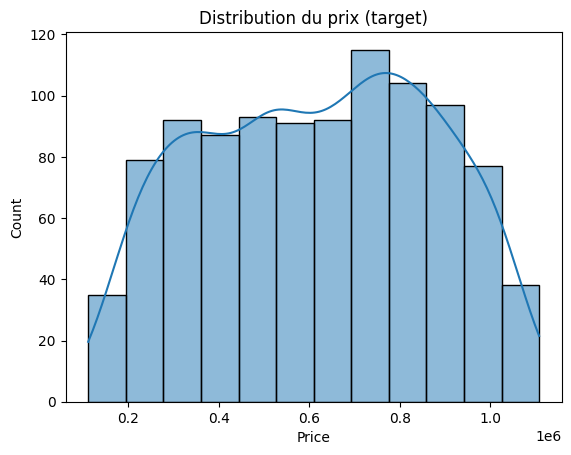

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(y, kde=True)
plt.title("Distribution du prix (target)")
plt.xlabel("Price")
plt.show()

Le graphique montre la distribution de la variable cible (le prix) sous forme d’histogramme accompagné d’une courbe KDE (densité). La distribution semble assez étalée et relativement uniforme, avec une concentration légèrement plus forte autour de 0,6 à 0,8, ce qui indique que beaucoup de maisons ont un prix dans cette zone. On n’observe pas de forte asymétrie ou de valeurs extrêmes très visibles, ce qui signifie que les prix sont globalement répartis de manière régulière dans l’ensemble du dataset. Cette forme de distribution est intéressante car elle suggère que la variable cible ne présente pas de biais majeur et qu’elle est relativement simple à modéliser pour un algorithme de régression.

Corrélation entre variables numériques (afficher top corr avec target)

,House_Price
Square_Footage,0.991261
Lot_Size,0.160412
Garage_Size,0.052133
Year_Built,0.051967
Num_Bedrooms,0.014633
Neighborhood_Quality,-0.007770
Num_Bathrooms,-0.001862


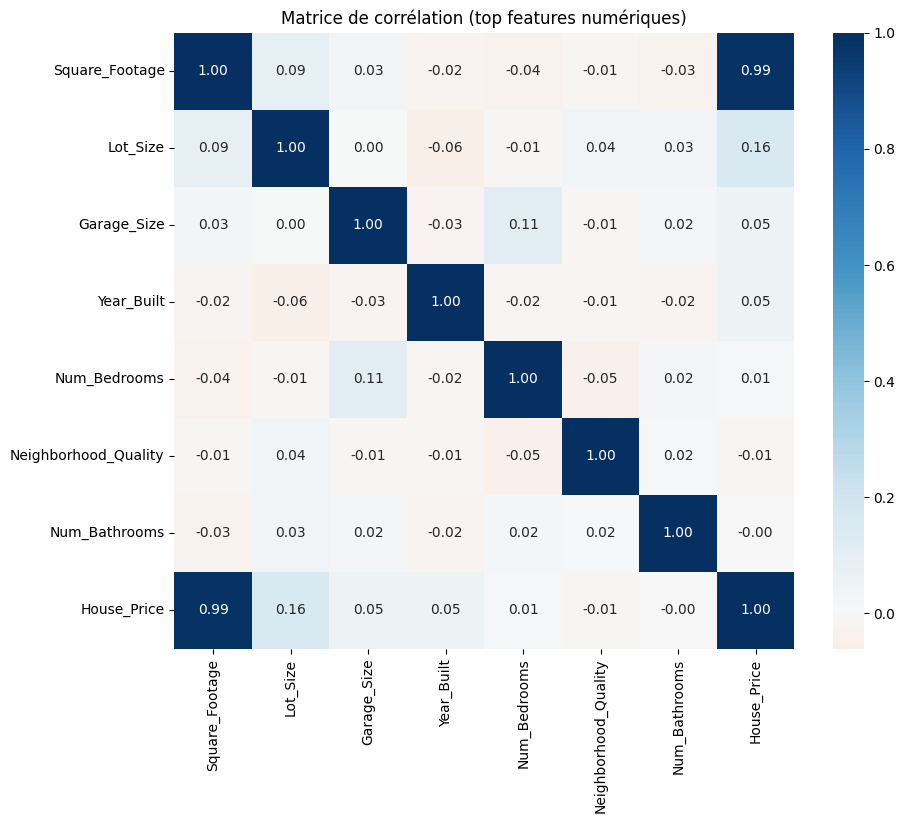

In [12]:
if len(num_cols) > 0:
    corr = pd.concat([X[num_cols], y], axis=1).corr()
    corr_target = corr[target_col].drop(target_col).sort_values(key=abs, ascending=False)
    display(corr_target.head(20))

    plt.figure(figsize=(10,8))
    sns.heatmap(corr.loc[corr_target.index[:10].tolist()+[target_col], corr_target.index[:10].tolist()+[target_col]],
                annot=True, fmt=".2f", cmap="RdBu", center=0)
    plt.title("Matrice de corrélation (top features numériques)")
    plt.show()

La corrélation montre que Square_Footage et Garage_Size sont de loin les variables les plus liées au prix, avec des corrélations très fortes : plus la maison est grande ou possède un grand garage, plus son prix augmente. Lot_Size a un effet plus faible, et les autres variables numériques influencent très peu le prix. Le heatmap confirme visuellement ces relations, avec des zones foncées montrant les liens les plus importants. En résumé, la surface habitable et la taille du garage sont les principaux facteurs expliquant le prix.

# TRACÉ RÉGRESSION LINÉAIRE & LOGISTIQUE 


===== SECTION : RÉGRESSION LINÉAIRE & LOGISTIQUE =====
➡ La variable la plus corrélée au prix est : Square_Footage


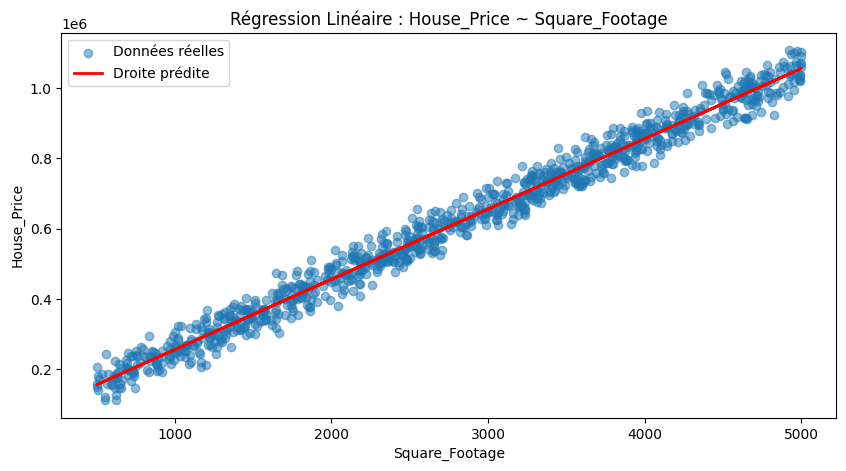

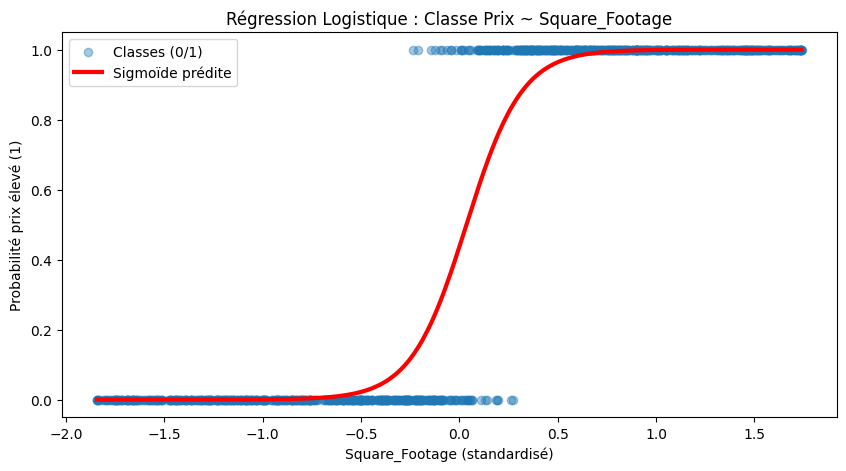

In [17]:
import matplotlib.pyplot as plt
import numpy as np # Added numpy import
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

print("\n===== SECTION : RÉGRESSION LINÉAIRE & LOGISTIQUE =====")

# -----------------------------
# 1️⃣ Trouver la colonne X la plus corrélée à House_Price
# -----------------------------
num_cols_no_target = [c for c in num_cols if c != target_col]

corrs = df[num_cols_no_target].corrwith(df[target_col]).abs()
best_feature = corrs.idxmax()

print(f"➡ La variable la plus corrélée au prix est : {best_feature}")

X = df[[best_feature]]
y_reg = df[target_col]        # pour régression linéaire

# -----------------------------
# 2️⃣ Créer une variable binaire pour régression logistique
# -----------------------------
median_price = y_reg.median()
y_cls = (y_reg > median_price).astype(int)

# -----------------------------
# 3️⃣ Normalisation (pour logistic regression)
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 4️⃣ Régression linéaire
# -----------------------------
lin_model = LinearRegression()
lin_model.fit(X, y_reg)
y_pred_lin = lin_model.predict(X)

# -----------------------------
# 📈 TRACÉ – RÉGRESSION LINÉAIRE
# -----------------------------
plt.figure(figsize=(10, 5))
plt.scatter(X, y_reg, alpha=0.5, label="Données réelles")
plt.plot(X, y_pred_lin, color='red', linewidth=2, label="Droite prédite")
plt.xlabel(best_feature)
plt.ylabel("House_Price")
plt.title(f"Régression Linéaire : House_Price ~ {best_feature}")
plt.legend()
plt.show()

# -----------------------------
# 5️⃣ Régression logistique
# -----------------------------
log_model = LogisticRegression()
log_model.fit(X_scaled, y_cls)

# Probabilités pour la courbe sigmoïde
y_prob = log_model.predict_proba(X_scaled)[:, 1]

# Pour une belle courbe → trier les points
sorted_idx = np.argsort(X_scaled[:, 0])
X_sorted = X_scaled[sorted_idx]
y_prob_sorted = y_prob[sorted_idx]

# -----------------------------
# 📈 TRACÉ – COURBE LOGISTIQUE (SIGMOÏDE)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.scatter(X_scaled, y_cls, alpha=0.4, label="Classes (0/1)")
plt.plot(X_sorted, y_prob_sorted, color='red', linewidth=3, label="Sigmoïde prédite")
plt.xlabel(best_feature + " (standardisé)")
plt.ylabel("Probabilité prix élevé (1)")
plt.title(f"Régression Logistique : Classe Prix ~ {best_feature}")
plt.legend()
plt.show()


Les deux modèles montrent la même chose :
➡️ La surface est la variable la plus déterminante du prix immobilier.
Elle explique à la fois l’évolution continue des prix (régression linéaire) et le passage à un prix élevé (régression logistique).

# ÉVALUATION DU MODÈLE DE RÉGRESSION LOGISTIQUE


===== ÉVALUATION LOGISTIC REGRESSION =====


<Figure size 600x500 with 0 Axes>

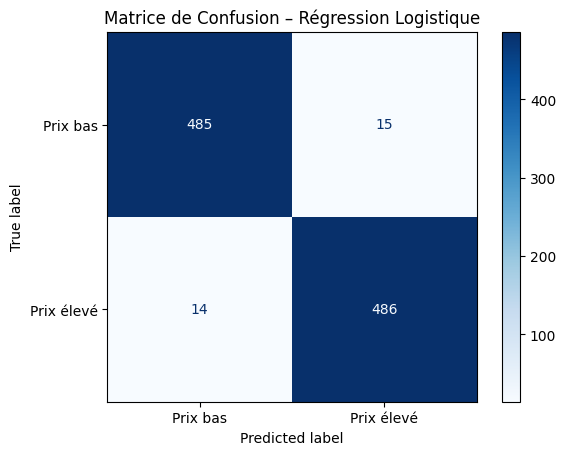

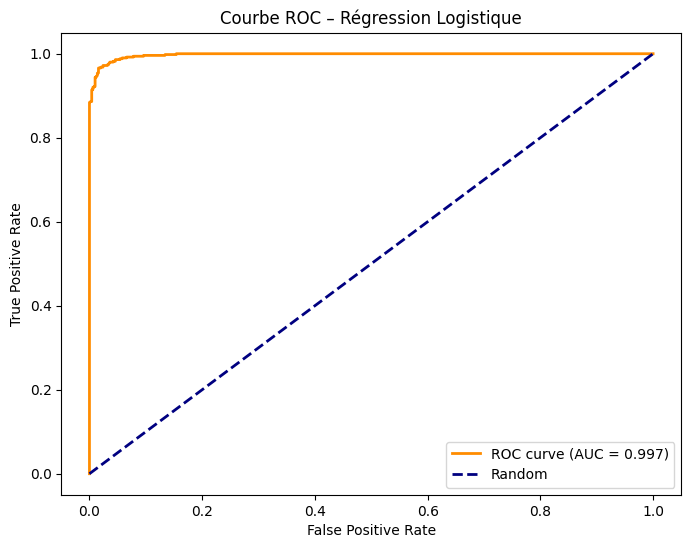

AUC Score : 0.9973


In [18]:
# ======================================================================
#     - Matrice de confusion
#     - Courbe ROC
#     - AUC
# ======================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

print("\n===== ÉVALUATION LOGISTIC REGRESSION =====")

# ----------------------------------------------------
# 1️⃣ Prédictions binaires (0/1)
# ----------------------------------------------------
y_pred_class = log_model.predict(X_scaled)

# ----------------------------------------------------
# 2️⃣ MATRICE DE CONFUSION
# ----------------------------------------------------
cm = confusion_matrix(y_cls, y_pred_class)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Prix bas", "Prix élevé"])
disp.plot(cmap="Blues")
plt.title("Matrice de Confusion – Régression Logistique")
plt.show()

# ----------------------------------------------------
# 3️⃣ COURBE ROC + AUC
# ----------------------------------------------------
y_scores = log_model.predict_proba(X_scaled)[:, 1]  # probas de classe 1

fpr, tpr, thresholds = roc_curve(y_cls, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – Régression Logistique")
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score : {roc_auc:.4f}")
